## Evaluate VAE (Encoder/Decoder quality)

The dataset used here is used later for training the RL agent, so we can perform a direct comparison between the results here and the results obtained from RL

In [41]:
from config import Config
from data_prep import DataPrep
from env import CMAPSSEnv

In [43]:
const = Config()
neurons = const.VAE_neurons

# Data prep
data = DataPrep(file = const.file_path,
                num_settings = const.num_settings,
                num_sensors = const.num_sensors,
                num_units = const.num_units[2],
                prev_step_units = const.prev_step_units[2],
                step = const.step[2],
                normalization_type="01")

df = data.ReadData()

In [44]:
df.head()

,Unit,NormTime,OpSetting1,OpSetting2,OpSetting3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,211,0.995327,0.833248,0.997625,1.0,0.060269,0.187903,0.333902,0.225908,0.146592,...,0.136443,0.993796,0.564038,0.343278,0.0,0.308511,0.651163,1.0,0.163861,0.165210
1,211,0.990654,0.999919,0.997862,1.0,0.000000,0.133493,0.286198,0.207650,0.000000,...,0.003173,0.993658,0.599009,0.367114,0.0,0.287234,0.627907,1.0,0.017863,0.021717
2,211,0.985981,0.476059,0.833017,1.0,0.626985,0.662033,0.643966,0.535748,0.507937,...,0.473287,0.993824,0.548079,0.321170,0.0,0.638298,0.864693,1.0,0.494675,0.493584
3,211,0.981308,0.999781,0.997625,1.0,0.000000,0.130731,0.302533,0.234678,0.000000,...,0.004391,0.993769,0.594056,0.364319,0.0,0.276596,0.627907,1.0,0.014772,0.018016
4,211,0.976636,0.833160,0.997625,1.0,0.060269,0.184588,0.324665,0.235570,0.146592,...,0.136621,0.994045,0.563088,0.344013,0.0,0.297872,0.651163,1.0,0.154930,0.160667


In [45]:
# List of engine lifetimes
engine_lives = df.groupby(df['Unit']).size().tolist()
num_engines = len(engine_lives)

In [46]:
# Load encoder and decoder
import tensorflow as tf

encoder = tf.keras.models.load_model("./saved_models/encoder", compile=False)
decoder = tf.keras.models.load_model("./saved_models/decoder", compile=False)

In [47]:
encoded_data = encoder.predict(df.iloc[:,1:])
decoded_data = decoder.predict(encoded_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

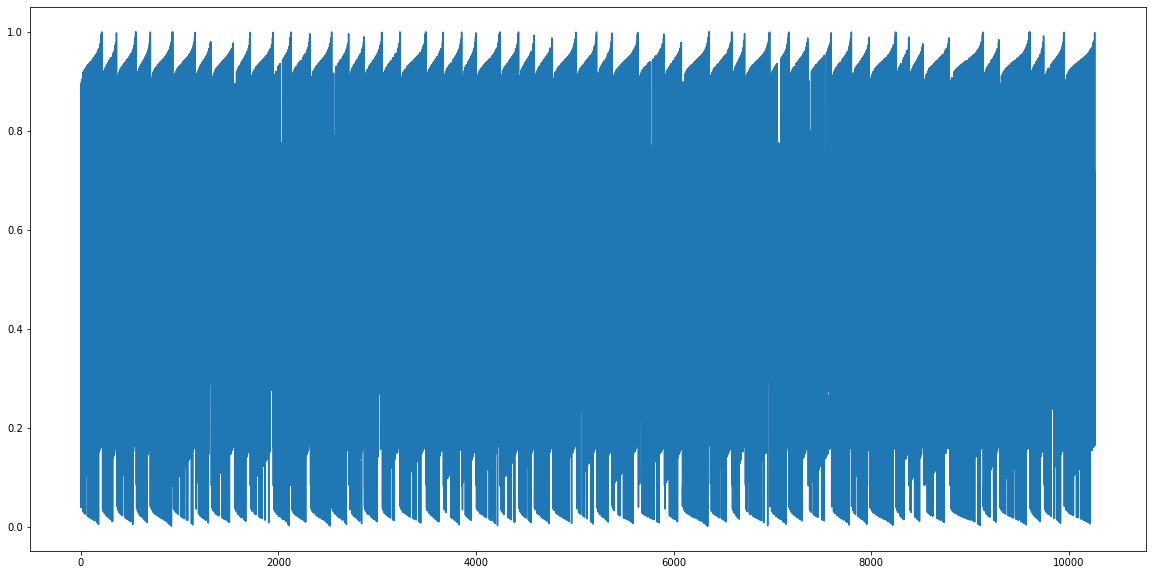

In [52]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(encoded_data)

In [49]:
import pandas as pd

decoded_df = pd.DataFrame(decoded_data, columns = df.columns[1:])

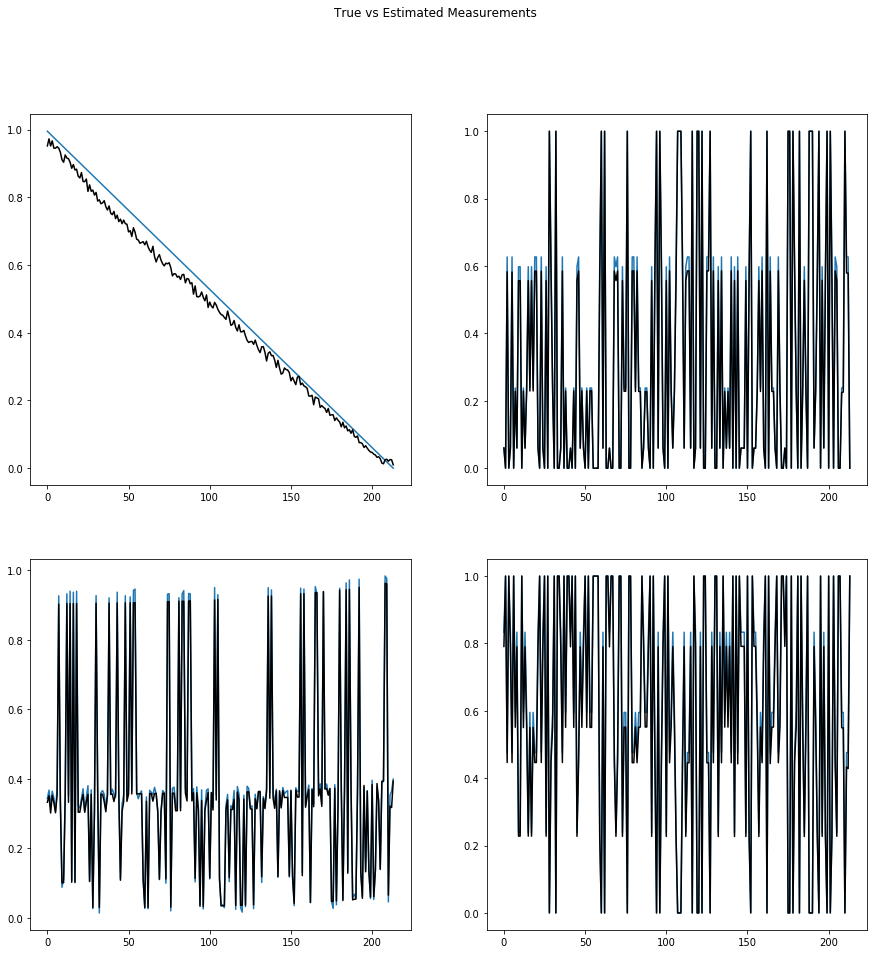

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('True vs Estimated Measurements')
plt.rcParams["figure.figsize"] = (10,10)

axs[0, 0].plot(df['NormTime'].iloc[0:engine_lives[0]])
axs[0, 0].plot(decoded_df['NormTime'].iloc[0:engine_lives[0]], color='black')

axs[0, 1].plot(df['Sensor1'].iloc[0:engine_lives[0]])
axs[0, 1].plot(decoded_df['Sensor1'].iloc[0:engine_lives[0]], color='black')

axs[1, 0].plot(df['Sensor15'].iloc[0:engine_lives[0]])
axs[1, 0].plot(decoded_df['Sensor15'].iloc[0:engine_lives[0]], color='black')

axs[1, 1].plot(df['OpSetting1'].iloc[0:engine_lives[0]])
axs[1, 1].plot(decoded_df['OpSetting1'].iloc[0:engine_lives[0]], color='black')

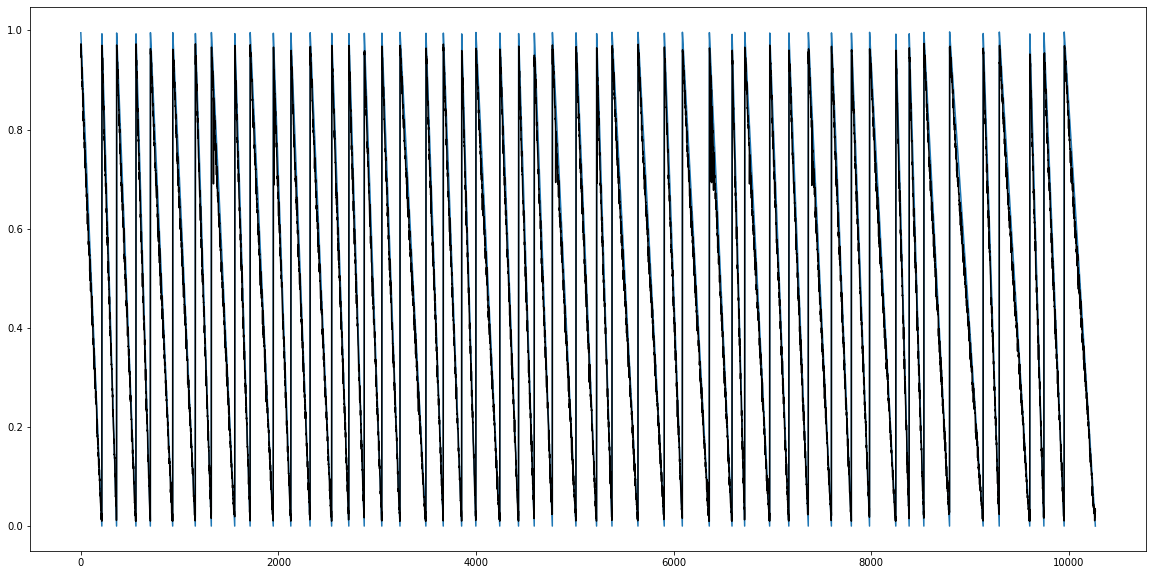

In [51]:
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(df['NormTime'])
plt.plot(decoded_df['NormTime'], color='black')

# Training agent using DDPG

Model-free, off-policy RL method.

Two networks here:
 - Actor: Proposes an action
 - Critic: Evaluates action based on new state, reward

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [15]:
# Experience Replay

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        
        #if len(path_to_save) > 0:
            #actor_model.save(path_to_save[0])
            #critic_model.save(path_to_save[1])

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, 
                    action_batch, 
                    reward_batch, 
                    next_state_batch)

# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
#@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [16]:
# Here we define the Actor and Critic networks. 

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="sigmoid", kernel_initializer=last_init)(out)

    # Our upper bound is 10.0 for x.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [17]:
# Returns an action sampled from our Actor network plus some noise for exploration.
def policy(state, noise_object, noise=True):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    if noise:
        sampled_actions = sampled_actions.numpy() + noise
    else:
        sampled_actions = sampled_actions.numpy()

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.asarray([np.squeeze(legal_action)])

## Training hyperparameters

In [18]:
from ray import serve

from config import Config
from data_prep import DataPrep
from env_no_serve import CMAPSSEnv
from tf_decoder_model import TFDecoderModel
from VAE_dense import *

In [19]:
const = Config()
neurons = const.VAE_neurons

# Data prep
data = DataPrep(file = const.file_path,
                num_settings = const.num_settings,
                num_sensors = const.num_sensors,
                num_units = const.num_units[1],
                prev_step_units = const.prev_step_units[1],
                step = const.step[1],
                normalization_type="01")

df = data.ReadData()

In [20]:
df.head()

,Unit,NormTime,OpSetting1,OpSetting2,OpSetting3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,201,0.994764,0.595107,0.738717,0.0,0.238089,0.004433,0.011404,0.000000,0.293184,...,0.089436,0.000580,0.042392,0.932427,0.0,0.010638,0.000000,0.0,0.142709,0.139905
1,201,0.989529,0.999905,0.997625,1.0,0.000000,0.117196,0.281772,0.218806,0.000000,...,0.002899,0.993542,0.574225,0.364798,0.0,0.287234,0.627907,1.0,0.013131,0.010608
2,201,0.984293,0.999817,0.999050,1.0,0.000000,0.120983,0.278546,0.222084,0.000000,...,0.002365,0.993514,0.578413,0.366169,0.0,0.276596,0.627907,1.0,0.013476,0.005870
3,201,0.979058,0.476163,0.831829,1.0,0.626985,0.654599,0.635476,0.542296,0.507937,...,0.472739,0.993624,0.517060,0.305635,0.0,0.648936,0.864693,1.0,0.494471,0.488823
4,201,0.973822,0.833196,0.997862,1.0,0.060269,0.175286,0.302996,0.221910,0.146592,...,0.135617,0.993680,0.537948,0.336198,0.0,0.297872,0.651163,1.0,0.155840,0.167383


In [21]:
len(df)

2032

In [22]:
# List of engine lifetimes
engine_lives = df.groupby(df['Unit']).size().tolist()
num_engines = len(engine_lives)

# Load decoder
decoder = tf.keras.models.load_model('./saved_models/decoder', compile=False)

# Environment types
env_types = ["batch", "intertemporal"]

##########################################
env_config = {
    "df": df,
    "timestep": 0,
    "obs_size": const.num_settings+const.num_sensors+1,
    "engines": num_engines,
    "engine_lives": engine_lives, 
    "decoder_model": decoder,
    "env_type": env_types[0],
}

env = CMAPSSEnv(**env_config)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print(upper_bound, lower_bound)

Size of State Space ->  25
Size of Action Space ->  1
1.0 0.0


In [23]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.02
actor_lr = 0.01

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.9
# Used to update target networks
tau = 0.05

buffer = Buffer(50000, 64)

In [ ]:
# To store reward history of each episode
rewards = []
# To store average reward history of last few episodes
avg_rewards = []
# To store rewards from episodes where no noise is applied
exploitation_rewards = []

for episode in range(total_episodes):

    episodic_reward = 0        
    prev_state = env.reset()
    
    while True:

        tf_prev_state = tf.reshape(prev_state, [1, -1])#tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise, noise=True)
        if episode % 5 == 0 and episode > 0:
            action = policy(tf_prev_state, ou_noise, noise=False)
        # Receive state and reward from environment.
        state, reward, done, _ = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    rewards.append(episodic_reward)
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_rewards.append(np.mean(rewards[-50:]))
    if episode % 5 == 0 and episode > 0:
        exploitation_rewards.append(episodic_reward)

data = {'Rewards':rewards,
       'Avg_rewards':avg_rewards}
results = pd.DataFrame(data) 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

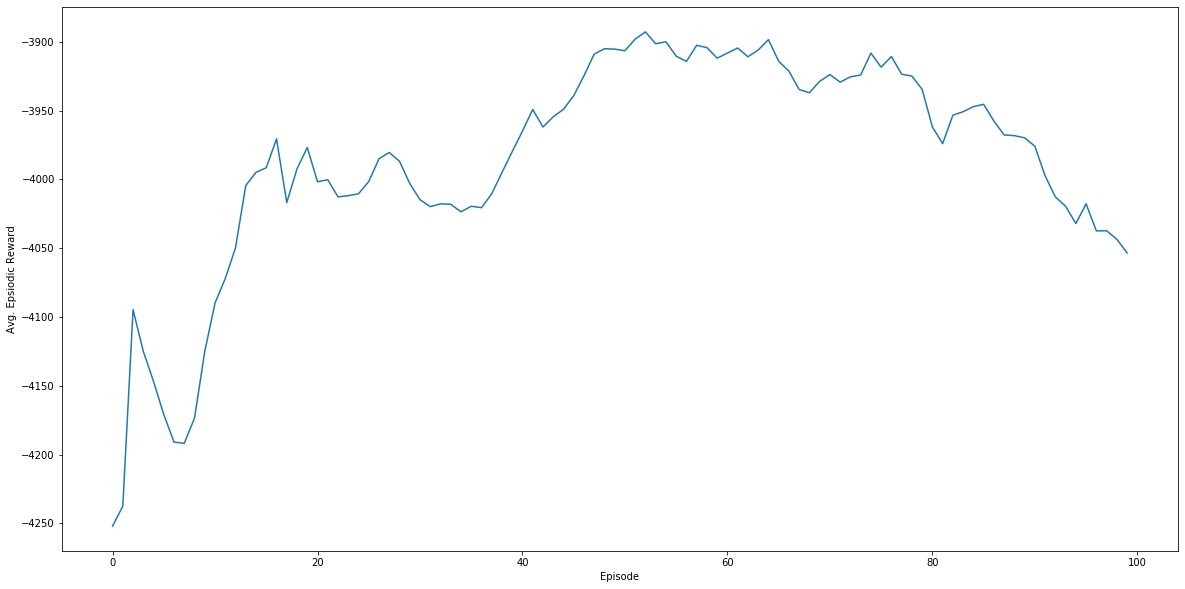

In [16]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(avg_reward_list)


# Plot results
plt.plot(results['Avg_rewards'])
plt.title(r'Average rewards $\sigma=0.1$')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(exploitation_rewards)
plt.title(r'Noise-free rewards $\sigma=0.1$')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.show()

In [17]:
actor_model.save('./saved_models/actor')
critic_model.save('./saved_models/critic')

target_actor.save('./saved_models/target_actor')
target_critic.save('./saved_models/target_critic')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

## Evaluate policy

In [18]:
# Test data
t_data = DataPrep(file = const.file_path,
                num_settings = const.num_settings,
                num_sensors = const.num_sensors,
                num_units = 20,
                prev_step_units = 240,
                step = const.step[2],
                normalization_type="01")

test_df = t_data.ReadData()
test_df

,Unit,NormTime,OpSetting1,OpSetting2,OpSetting3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,241,0.994536,0.595099,0.736342,0.0,0.238089,0.010311,0.051374,0.010265,0.293184,...,0.088637,0.001434,0.060915,0.915211,0.0,0.031915,0.000000,0.0,0.136864,0.142847
1,241,0.989071,0.999976,0.997625,1.0,0.000000,0.128061,0.287673,0.226278,0.000000,...,0.003430,0.993245,0.573673,0.384477,0.0,0.287234,0.627907,1.0,0.012036,0.008898
2,241,0.983607,0.000038,0.001188,1.0,1.000000,0.985454,0.937133,0.936451,1.000000,...,0.997714,0.993493,0.709531,0.042082,1.0,0.946809,1.000000,1.0,0.986589,0.985913
3,241,0.978142,0.833151,0.998694,1.0,0.060269,0.183392,0.326677,0.227443,0.146592,...,0.134517,0.993410,0.532670,0.344712,0.0,0.308511,0.651163,1.0,0.151994,0.153282
4,241,0.972678,0.476128,0.831354,1.0,0.626985,0.661941,0.648225,0.551313,0.507937,...,0.471915,0.993769,0.529251,0.333493,0.0,0.617021,0.864693,1.0,0.486245,0.496670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4359,260,0.012658,0.476188,0.831354,1.0,0.626985,0.674461,0.690850,0.591580,0.507937,...,0.468918,0.996250,0.807527,0.351775,1.0,0.691489,0.864693,1.0,0.484869,0.480615
4360,260,0.009494,0.238102,0.298100,1.0,0.597937,0.647026,0.742197,0.726984,0.617180,...,0.614155,0.994596,0.997888,0.151333,1.0,0.744681,0.854123,1.0,0.613480,0.620190
4361,260,0.006329,0.595222,0.736342,0.0,0.238089,0.017952,0.089171,0.066946,0.293184,...,0.087061,0.007279,0.308771,1.000000,0.0,0.063830,0.000000,0.0,0.135144,0.137297
4362,260,0.003165,0.595203,0.738717,0.0,0.238089,0.021267,0.080147,0.087724,0.293184,...,0.088662,0.007334,0.311838,0.995586,0.0,0.074468,0.000000,0.0,0.130330,0.127092


In [19]:
len(test_df)

4364

In [20]:
# List of engine lifetimes
engine_lives = test_df.groupby(test_df['Unit']).size()
engine_lives = engine_lives.tolist()
num_engines = len(engine_lives)

print(engine_lives, num_engines)

[183, 273, 230, 128, 253, 194, 197, 234, 202, 184, 266, 135, 149, 260, 340, 163, 309, 143, 205, 316] 20


In [21]:
# Environment types
env_types = ["batch", "intertemporal"]

##########################################
env_config = {
    "df": df,
    "timestep": 0,
    "obs_size": const.num_settings+const.num_sensors+1,
    "engines": num_engines,
    "engine_lives": engine_lives, 
    "decoder_model": decoder,
    "env_type": env_types[0],
}

print("env_config: ", env_config)

env_config:  {'df':       Unit  NormTime  OpSetting1  OpSetting2  OpSetting3   Sensor1   Sensor2  \
0      241  0.994536    0.595099    0.736342         0.0  0.238089  0.010311   
1      241  0.989071    0.999976    0.997625         1.0  0.000000  0.128061   
2      241  0.983607    0.000038    0.001188         1.0  1.000000  0.985454   
3      241  0.978142    0.833151    0.998694         1.0  0.060269  0.183392   
4      241  0.972678    0.476128    0.831354         1.0  0.626985  0.661941   
...    ...       ...         ...         ...         ...       ...       ...   
4359   260  0.012658    0.476188    0.831354         1.0  0.626985  0.674461   
4360   260  0.009494    0.238102    0.298100         1.0  0.597937  0.647026   
4361   260  0.006329    0.595222    0.736342         0.0  0.238089  0.017952   
4362   260  0.003165    0.595203    0.738717         0.0  0.238089  0.021267   
4363   260  0.000000    0.833260    0.997625         1.0  0.060269  0.194347   

       Sensor3   Se

In [36]:
env = CMAPSSEnv(**env_config)

# Load trained actor
target_actor = tf.keras.models.load_model('./saved_models/actor', compile=False)

In [38]:
est_rul = []
est_sensor1 = []
action_vector = []

#for s in range(len(test_df)):
state = tf.expand_dims(env.reset(), 0)
action = target_actor(state, training=False).numpy()[0]
action_vector.append(action)
obs, _, _, _ = env.step(action)
est_rul.append(obs[0])
est_sensor1.append(obs[5])
for t in range(1,engine_lives[0]):
    action = target_actor(state, training=False).numpy()[0]
    action_vector.append(action)
    obs, _, _, _ = env.step(action)
    est_rul.append(obs[0])
    est_sensor1.append(obs[5])
    state = tf.reshape(tf.constant(obs),[1,25])
    #print(rew, done)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


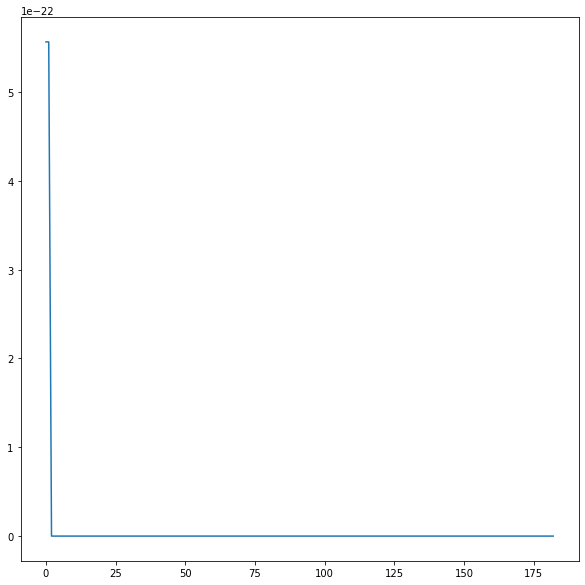

[array([5.562701e-22], dtype=float32), array([5.562701e-22], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32),

In [39]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

plt.plot(action_vector)
plt.show()
print(action_vector)

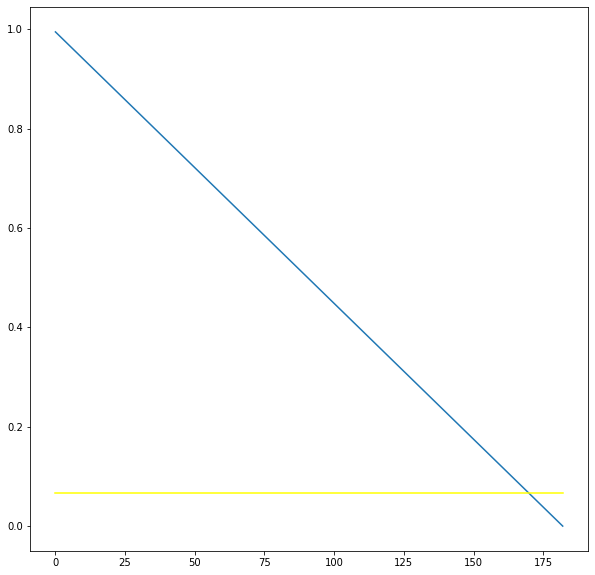

In [25]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

plt.plot(test_df['NormTime'][:engine_lives[0]])
plt.plot(est_rul, color='yellow')
plt.show()

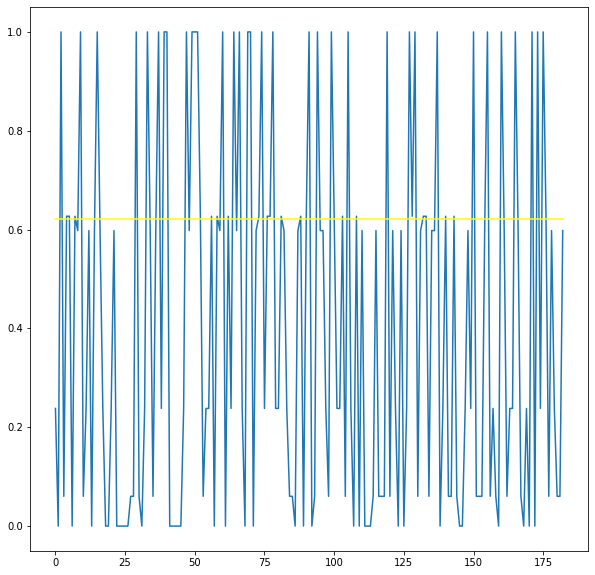

In [25]:
plt.plot(test_df['Sensor1'][:engine_lives[0]])
plt.plot(est_sensor1, color='yellow')
plt.show()